# Running from R

## Foreword
<b>dandelion</b> is written in `python==3.7.6` and it is primarily a single-cell BCR-seq analysis package. It makes use of some tools from the fantastic [immcantation suite](https://immcantation.readthedocs.io/) and the main idea is that it implements a workflow for the pre-processing and exploratory stages with integrated use of tools from *immcantation* for the BCR side of things and analysis tools from [*scanpy*](https://scanpy.readthedocs.io/) for the RNA-seq side of things. I hope to be able to introduce some new single-cell BCR-seq exploratory tools down the road through *dandelion*. 

<b>dandelion</b> can be run in `R` through `reticulate`. This section will try to replicate the examples using `R`. 

There are some issues with the conversion of dataframes between python and R so I would <b>not</b> recommend saving the final `AnnData` object as a final out file, but only use this to help generate the intermediate files from the BCR processing and the plots. Please store your original analysis some where safe. I would also skip quantify mutation step due to conflicts between rpy2 and reticulate.

For more details, please refer to the original python tutorial.

Let's start!

First, install reticulate via if you don't already have it:

`install.packages("reticulate")`

In [1]:
library(reticulate)
use_condaenv("dandelion")
# or use Sys.setenv(RETICULATE_PYTHON = conda_python(envname='dandelion'))


You can check if the python config is set up properly with `py_config()`

In [2]:
py_config()


Warning message in system2("poetry", c("env", "info", "--path"), stdout = TRUE):
“running command ''poetry' env info --path' had status 1”


python:         /opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/bin/python
libpython:      /opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/libpython3.11.dylib
pythonhome:     /opt/homebrew/Caskroom/mambaforge/base/envs/dandelion:/opt/homebrew/Caskroom/mambaforge/base/envs/dandelion
version:        3.11.4 | packaged by conda-forge | (main, Jun 10 2023, 18:08:41) [Clang 15.0.7 ]
numpy:          /opt/homebrew/Caskroom/mambaforge/base/envs/dandelion/lib/python3.11/site-packages/numpy
numpy_version:  1.24.4

NOTE: Python version was forced by use_python function

To proceed with the analyses, we first change the working directory and also import the dandelion module.

In [3]:
# change directory to somewhere more workable
setwd("~/Downloads/dandelion_tutorial/")
ddl <- import("dandelion")


As per reticulate convention, python `.` operators are to be swaped with `$` in R.

## Pre-processing
To being the BCR preprocessing, the minimum files you require are the following:
```console
filtered_contig.fasta
filtered_contig_annotations.csv
```

### Step 1: Formatting the headers of the Cell Ranger fasta file
This will do the following:
1) add the prefix provided to every sequence header

2) add the prefix provided to every contig_id in the annotation.csv file

3) create a folder called `dandelion/data` (if left as default) and saves a copy of these files in that directory.

In [4]:
# the first option is a list of fasta files to format and the second option is the list of prefix to add to each file.
samples <- c("sc5p_v2_hs_PBMC_1k", "sc5p_v2_hs_PBMC_10k", "vdj_v1_hs_pbmc3", "vdj_nextgem_hs_pbmc3")
ddl$pp$format_fastas(samples, prefix = samples)


### Step 2: Reannotate the V/D/J genes with *igblastn*.

`ddl$pp$reannotate_genes` uses [*changeo*](https://changeo.readthedocs.io/en/stable/examples/10x.html)'s scripts to call *igblastn* to reannotate the fasta files. Depending on the `fileformat` option, it will parse out as either an `airr` (default) or `changeo`-legacy TSV file. Importantly, with the recent update to changeo v1.0.0, all the column headers, including *changeo* format, are now adhereing to the [*AIRR*](http://docs.airr-community.org/) standard (lowercase and some column name changes). Specifying `extended = True` will return the additional 10x annotation of V/D/J genes but they are unnecessary at this stage.

In [5]:
ddl$pp$reannotate_genes(samples)


you should see something like this in the terminal:
```console
Assigning genes :   0%|                                        | 0/4 [00:00<?, ?it/s]   
START> AssignGenes
 COMMAND> igblast
 VERSION> 1.15.0
    FILE> sc5p_v2_hs_PBMC_10k_b_filtered_contig.fasta
ORGANISM> human
    LOCI> ig
   NPROC> 4

PROGRESS> 12:30:37 |Running IgBLAST          | 0.0 min

```

### Step 3 : Reassigning heavy chain V gene alleles *(optional but recommended)*

Next, we use *immcantation's TIgGER* method to reassign allelic calls for heavy chain V genes with `pp.reassign_alleles`. As stated in TIgGER's [website](https://tigger.readthedocs.io/en/stable/) and [manuscript](https://pubmed.ncbi.nlm.nih.gov/25675496/), *'TIgGER is a computational method that significantly improves V(D)J allele assignments by first determining the complete set of gene segments carried by an individual (including novel alleles) from V(D)J-rearrange sequences. TIgGER can then infer a subject’s genotype from these sequences, and use this genotype to correct the initial V(D)J allele assignments.'*

This impact's on how contigs are chosen for finding clones later so it is highly recommended to run it. It is also important when considering to do mutational analysis. 

However, the main caveat is that this needs to be run on multiple samples from the same subject to allow for more information to be used to confidently assign a genotyped *v_call*. In this tutorial, I'm assuming the four samples can be split into two sets where sets of two corresponds to a different/single individual. So while important, this step can be skipped if you don't have the samples to do this. 

`pp.reassign_alleles` requires the `combined_folder` option to be specified so that a merged/concatenated file can be produced for running TIgGER. The function also runs `pp.create_germlines` using the germline database updated with the germline corrections from TIgGER. The default behavior is that it will return a `germline_alignment_d_mask` column in the final output. This can be changed by specifying `germ_types` option; see [here](https://changeo.readthedocs.io/en/stable/tools/CreateGermlines.html#creategermlines) for other options.

Specifying `fileformat = 'changeo'` will run on changeo formatted files if this was run earlier; but it's probably best to stick to airr's standard format.

In [6]:
# reassigning alleles on the first set of samples
ddl$pp$reassign_alleles(samples[1:2], combined_folder = "tutorial_scgp1")


In [7]:
# reassigning alleles on the first set of samples
ddl$pp$reassign_alleles(samples[3:4], combined_folder = "tutorial_scgp2")


We can see that most of the original ambiguous V calls have now been corrected and only a few remain. These will be flagged as multi later on and can probably be excluded from detailed analyses. For now, leaving them in the data will not impact on subsequent analyses. 

## Step 4: Assigning constant region calls

Cell Ranger's annotation files provides a *c_gene* column, but rather than simply relying on Cell Ranger's annotation, it is common to use [*immcantation-presto*'s *MaskPrimers.py*](https://presto.readthedocs.io/en/version-0.5.3---license-change/tools/MaskPrimers.html) with a custom primer list. 

As an alternative, `dandelion` includes a pre-processing function, `pp.assign_isotypes`, to use *blastn* to annotate constant region calls for all contigs and retrieves the call, merging it with the tsv files. This function will overwrite the output from previous steps and add a *c_call* column at the end, or replace the existing column if it already exists. The Cell Ranger calls are returned as `c_call_10x`.

Further, to deal with incorrect constant gene calls due to insufficient length, a pairwise alignment will be run against [curated sequences](https://immunology.sciencemag.org/content/6/56/eabe6291) that were deemed to be highly specific in distinguishing `IGHA1` vs `IGHA2`, and `IGHG1` to `IGHG4`. I have also curated sets of sequences that should help deal with `IGLC3/6/7` as these are problematic too. If there is insufficient info, the `c_call` will be returned as a combination of the most aligned sets of sequences. Because of how similar the lambda light chains are, extremely ambiguous calls (only able to map to a common sequence across the light chains) will be returned as `IGLC`. This typically occurs when the constant sequence is very short. Those that have equal alignment scores between `IGLC3/6/7` sequences and the common sequence will be returned as a concatenated call; for example, a contig initially annotated as `IGLC3` will be returned as `IGLC,IGLC3`. 

In [8]:
ddl$pp$assign_isotypes(samples)


<div class="alert alert-info">

Note
    
Should you want to use a different reference fasta file for this step, run with the following option:

```R
ddl$pp$assign_isotypes(samples, blastdb = "path/to/custom_BCR_constant.fasta")
```

The default option will return a summary plot that can be disabled with `plot = FALSE`.
</div>

It's worthwhile to manually check the the sequences for constant calls returned as IGHA1-2, IGHG1-4 and the light chains and manually correct them if necessary.

### Step 5: Quantify mutations *(optional)*.

In the python tutorial, at this stage, I quantified the basic mutational load with `ddl.pp.quantify_mutations` before subsequent analyses. This would not run properly within this R session due to rpy2/reticulate conflict. Instead, i'd recommend you to run this separately on the. `*_contig_dandelion.tsv` file that was generated in the previous step, by following [Shazam's tutorial](https://shazam.readthedocs.io/en/stable/vignettes/Mutation-Vignette/) on basic mutational analysis, before continuing.

## Filtering

**Create a Seurat object from the transcriptome data**

Let's first import the gene expression data. Let's try from Seurat object.

In [5]:
setwd("~/Downloads/dandelion_tutorial/")
library(Seurat)
samples <- c("sc5p_v2_hs_PBMC_1k", "sc5p_v2_hs_PBMC_10k", "vdj_v1_hs_pbmc3", "vdj_nextgem_hs_pbmc3")
seurat_objects <- list()
for (i in 1:length(samples)) {
    filename <- paste0(samples[i], "/filtered_feature_bc_matrix.h5")
    data <- Read10X_h5(filename)
    seurat_objects[[i]] <- CreateSeuratObject(counts = data$`Gene Expression`)
}


Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome

Genome matrix has multiple modalities, returning a list of matrices for this genome



In [6]:
# merge them, there's probably better ways
merged1 <- merge(seurat_objects[[1]], seurat_objects[[2]], add.cell.ids = samples[1:2])
merged2 <- merge(seurat_objects[[3]], seurat_objects[[4]], add.cell.ids = samples[3:4])
merged <- merge(merged1, merged2)


In [7]:
head(merged@meta.data)


,orig.ident,nCount_RNA,nFeature_RNA
,<chr>,<dbl>,<int>
sc5p_v2_hs_PBMC_1k_AAACCTGCAGCCTGTG-1,SeuratProject,5029,1819
sc5p_v2_hs_PBMC_1k_AAACGGGTCGCTGATA-1,SeuratProject,4343,1738
sc5p_v2_hs_PBMC_1k_AAAGATGTCCTCGCAT-1,SeuratProject,898,554
sc5p_v2_hs_PBMC_1k_AAAGCAAAGTATGACA-1,SeuratProject,4999,1796
sc5p_v2_hs_PBMC_1k_AAAGCAATCCATTCTA-1,SeuratProject,601,416
sc5p_v2_hs_PBMC_1k_AAATGCCCACTTAAGC-1,SeuratProject,4998,1530


`dandelion` removes hyphen from the cell barcodes as a default behaviour, so we will do the same for the `Seurat` object.

In [8]:
# remove the -# from the end of each cell name
merged <- RenameCells(merged, new.names = gsub("-.*", "", row.names(merged@meta.data)))
merged


An object of class Seurat 
38224 features across 30471 samples within 1 assay 
Active assay: RNA (38224 features, 0 variable features)

<b>Standard Seurat pre-processing workflow</b>

In [9]:
merged[["percent.mt"]] <- PercentageFeatureSet(merged, pattern = "^MT-")
merged <- subset(merged, subset = nFeature_RNA > 200 & nFeature_RNA < 2500 & percent.mt < 5)
merged <- NormalizeData(merged)
merged <- FindVariableFeatures(merged, selection.method = "vst", nfeatures = 2000)
merged <- ScaleData(merged)
merged <- RunPCA(merged, features = VariableFeatures(object = merged))
merged <- FindNeighbors(merged, dims = 1:50)
merged <- FindClusters(merged)
merged <- RunUMAP(merged, dims = 1:50)


Centering and scaling data matrix

PC_ 1 
Positive:  LYZ, S100A9, FCN1, S100A8, CST3, VCAN, MNDA, IFI30, SPI1, SERPINA1 
	   S100A12, CSTA, TYMP, CTSS, CD14, LST1, CYBB, FTL, MS4A6A, CSF3R 
	   TYROBP, CD68, TNFAIP2, CFD, NCF2, CD36, CEBPD, AIF1, GRN, LILRB2 
Negative:  IFITM1, RPS27, IL32, LTB, RPS12, RPS18, IL7R, TCF7, CD7, TRBC2 
	   NOSIP, RPS29, LEF1, LINC00861, ETS1, CD247, CCR7, LIME1, CD2, MAL 
	   SELL, GZMM, TRBC1, AQP3, OXNAD1, AES, CD69, ARL4C, PIM2, TRAC 
PC_ 2 
Positive:  MS4A1, CD79A, BANK1, LINC00926, IGHM, HLA-DQA1, FCER2, HLA-DQB1, TCL1A, CD79B 
	   FCRLA, CD19, VPREB3, RALGPS2, CD22, HLA-DRA, FCRL1, HLA-DOB, AFF3, NIBAN3 
	   IGHD, POU2AF1, BLNK, BLK, HLA-DPB1, SPIB, IGKC, ADAM28, CD24, HVCN1 
Negative:  NKG7, HCST, CST7, PRF1, GZMA, GNLY, CTSW, KLRD1, IFITM1, FGFBP2 
	   FCGR3A, KLRF1, SPON2, S100A4, HOPX, GZMB, SRGN, IFITM2, CCL5, CLIC3 
	   CD7, MATK, ITGB2, TBX21, IL2RB, CD247, KLRB1, GZMM, SH2D1B, S1PR5 
PC_ 3 
Positive:  NKG7, GNLY, GZMB, CST7, PRF1, KLRD1, GZM

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 18634
Number of edges: 809571

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.9226
Number of communities: 24
Elapsed time: 2 seconds


Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
00:02:23 UMAP embedding parameters a = 0.9922 b = 1.112

00:02:23 Read 18634 rows and found 50 numeric columns

00:02:23 Using Annoy for neighbor search, n_neighbors = 30

00:02:23 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

00:02:25 Writing NN index file to temp file /var/folders/_r/j_8_fj3x28n2th3ch0ckn9c40000gt/T//RtmpfKS4Qx/filea8756193a1af

00:02:25 Searching Annoy index using 1 thread, search_k = 3000

00:02:28 Annoy recall = 100%

00:02:29 Commencing smooth kNN distance calibra

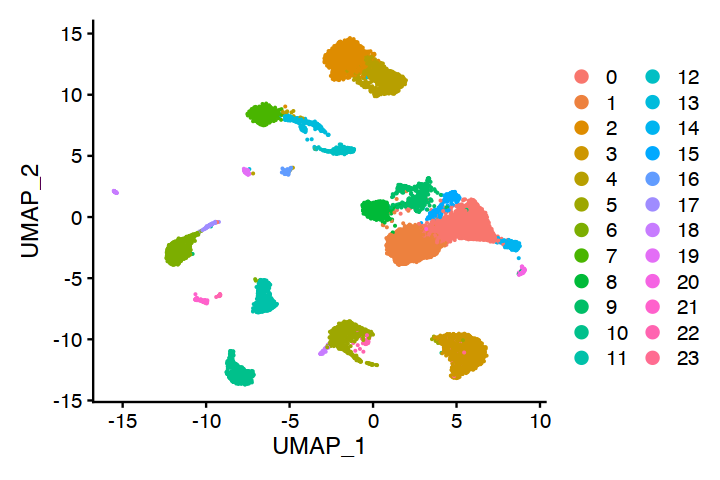

In [10]:
options(repr.plot.width = 6, repr.plot.height = 4)
DimPlot(merged, reduction = "umap")


In [11]:
merged


An object of class Seurat 
38224 features across 18634 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

In order for `dandelion` to do the next step (marking/filtering of poor quality BCRs and BCR doublets), we need to include a column in the metadata, `filter_rna`. This column will tell `dandelion` whether or not the cell has passed transcriptomic QCs. So, we will set the column to `FALSE` i.e. every cell passed QC. This is important because we want to remove as many doublets and poor quality contigs to save time on computation and construction of the final data tables.

<b>Convert to AnnData</b>

We will need to convert the `Seurat` object to `AnnData` to be able to continue.
`AnnData` `.obs` slot is essentially the same as `@meta.data` in seurat.

In [12]:
library(reticulate)
sc <- import("scanpy")
# convert the meta.data slot to a python friendly object
obs <- r_to_py(merged@meta.data)
normcounts <- r_to_py(Matrix::t(GetAssayData(merged)))


In [13]:
adata <- sc$AnnData(X = normcounts, obs = obs)
adata


AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters'

<b>Read in the BCR files and merge them</b>

In [14]:
files <- list()
for (i in 1:length(samples)) {
    filename <- paste0(samples[i], "/dandelion/filtered_contig_dandelion.tsv")
    files[[i]] <- readr::read_tsv(filename)
}
combined_bcr <- do.call(rbind, files)
head(combined_bcr)


Rows: 183 Columns: 120
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (54): sequence_id, sequence, v_call, d_call, j_call, sequence_alignment,...
dbl (60): junction_length, np1_length, np2_length, v_sequence_start, v_seque...
lgl  (6): rev_comp, productive, stop_codon, vj_in_frame, j_source, complete_vdj

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 2392 Columns: 120
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (54): sequence_id, sequence, v_call, d_call, j_call, sequence_alignment,...
dbl (60): junction_length, np1_length, np2_length, v_sequence_start, v_seque...
lgl  (6): rev_comp, productive, stop_codon, vj_in_frame,

sequence_id,sequence,rev_comp,productive,v_call,d_call,j_call,sequence_alignment,germline_alignment,junction,⋯,v_sequence_alignment_aa,d_sequence_alignment_aa,j_sequence_alignment_aa,complete_vdj,j_call_multimappers,j_call_multiplicity,j_call_sequence_start_multimappers,j_call_sequence_end_multimappers,j_call_support_multimappers,mu_count
<chr>,<chr>,<lgl>,<lgl>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<lgl>,<chr>,<dbl>,<chr>,<chr>,<chr>,<dbl>
sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_1,ACTGCGGGGGTAAGAGGTTGTGTCCACCATGGCCTGGACTCCTCTCCTCCTCCTGTTCCTCTCTCACTGCACAGGTTCCCTCTCGCAGGCTGTGCTGACTCAGCCGTCTTCCCTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTTGGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGACTCAGATAAGCAGCAGGGCTCTGGAGTCCCCAGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAGGTCAGCCCAAGGCTGCCCCCTCGGTCACTCTGTTCCCGCCCTCCTCTGAGGAGCTTCAAGCCAACAAGGCCACACTGGTGTGTCTCATAAGTGACTTCTACCCGGGAGCCGTGACAGTGGCCTGGAAGGCAGATAGCAGCCCCGTCAAGGCGGGAGTGGAGACCACCACACCCTCCAAACAAAGCAACAACAAGTACGCGGCCAGCAGCTA,FALSE,TRUE,IGLV5-45*03,NA,IGLJ3*02,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTT.........GGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGAC.........TCAGATAAGCAGCAGGGCTCTGGAGTCCCC...AGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAG,CAGGCTGTGCTGACTCAGCCGTCTTCC...CTCTCTGCATCTCCTGGAGCATCAGCCAGTCTCACCTGCACCTTGCGCAGTGGCATCAATGTT.........GGTACCTACAGGATATACTGGTACCAGCAGAAGCCAGGGAGTCCTCCCCAGTATCTCCTGAGGTACAAATCAGAC.........TCAGATAAGCAGCAGGGCTCTGGAGTCCCC...AGCCGCTTCTCTGGATCCAAAGATGCTTCGGCCAATGCAGGGATTTTACTCATCTCTGGGCTCCAGTCTGAGGATGAGGCTGACTATTACTGTATGATTTGGCACAGCAGCGCTTGGGTGTTCGGCGGAGGGACCAAGCTGACCGTCCTAG,TGTATGATTTGGCACAGCAGCGCTTGGGTGTTC,⋯,QAVLTQPSSLSASPGASASLTCTLRSGINVGTYRIYWYQQKPGSPPQYLLRYKSDSDKQQGSGVPSRFSGSKDASANAGILLISGLQSEDEADYYCMIWHSSA,NA,VFGGGTKLTVL,NA,IGLJ3*01,1,397,431,4.91e-13,0
sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_2,ATACTTTCTGAGAGTCCTGGACCTCCTGTGCAAGAACATGAAACATCTGTGGTTCTTCCTCCTCCTGGTGGCAGCTCCCAGATGGGTCCTGTCCCAGGTGCAGCTGCAGGAGTCGGGCCCAGGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGCAGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGTGGGAGCACCAACTACAACCCCTCCCTCAAGAGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTGCGGACGTCTGGGGCCAAGGGACCACGGTCACCGTCTCCTCAGGGAGTGCATCCGCCCCAACCCTTTTCCCCCTCGTCTCCTGTGAGAATTCCCCGTCGGATACGAGCAGCGTG,FALSE,TRUE,IGHV4-61*02,IGHD3-3*01,IGHJ6*02,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGC......AGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGT.........GGGAGCACCAACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTGCGGACGTCTGGGGCCAAGGGACCACGGTCACCGTCTCCTCA,CAGGTGCAGCTGCAGGAGTCGGGCCCA...GGACTGGTGAAGCCTTCACAGACCCTGTCCCTCACCTGCACTGTCTCTGGTGGCTCCATCAGC......AGTGGTAGTTACTACTGGAGCTGGATCCGGCAGCCCGCCGGGAAGGGACTGGAGTGGATTGGGCGTATCTATACCAGT.........GGGAGCACCAACTACAACCCCTCCCTCAAG...AGTCGAGTCACCATATCAGTAGACACGTCCAAGAACCAGTTCTCCCTGAAGCTGAGCTCTGTGACCGCCGCAGACACGGCCGTGTATTACTGTGCGAGAGANNATTACGATTTTTGGAGTGGTTATTACTACGGTATGGACGTCTGGGGCCAAGGGACCACGGTCACCGTCTCCTCA,TGTGCGAGAGAAAATTACGATTTTTGGAGTGGTTATTACCACGGTGCGGACGTCTGG,⋯,QVQLQESGPGLVKPSQTLSLTCTVSGGSISSGSYYWSWIRQPAGKGLEWIGRIYTSGSTNYNPSLKSRVTISVDTSKNQFSLKLSSVTAADTAVYYCAR,YDFWSGY,YHGADVWGQGTTVTVSS,NA,IGHJ6*02,1,416,469,1.14e-18,3
sc5p_v2_hs_PBMC_1k_AACTCCCAGGCTAGGT_contig_3,GGCTGGGGTCTCAGGAGGCAGCGCTCTGGGGACGTCTCCACCATGGCCTGGGCTCTGCTCCTCCTCACCTCCTCACTCAGGGCACAGGCTCTTGGGCCCAGTCTGCCCTGATTCAGCCTCCCTCCGTGTCCGGGTCTCCTGGACAGTCAGTCACCATCTCCTGCACTGGAACCAGCAGTGATGTTGGGAGTTATGA

### Run `ddl$pp$filter_contigs`

In [15]:
vdj_results_list <- ddl$pp$filter_contigs(combined_bcr, adata)
vdj_results_list


[[1]]
Dandelion class object with n_obs = 812 and n_contigs = 1657
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_lengt

This returns a two level list in R. The first level is the VDJ results, stored as a `Dandelion` python-class object and the second level is the accompanying `AnnData` object. 

The `Dandelion` class is structured like a multi-slot object and the two data frames below are linked:
1) data <- AIRR table with row names as individual vdj contigs 

2) metadata <- AIRR table collapsed to cell barcodes as row names

More details on the `Dandelion` class are in my python tutorials. The most important slot for now, is the `metadata` slot within `Dandelion`.

In order for the `metadata` to form properly, there must not be any duplicate barcodes, or incorrectly retrieved information from the `data` slot. If you end up with a `Dandelion` object that only contains the `data` slot filled, it means one of the two conditions happened. In those situations, I would recommend you to send me a copy of the file so I can check why it's failing; it is usually due to coding eror that arise from string and float incompatibilities when constructing the object.

To save the `Dandelion` object, you can do the following:

In [16]:
vdj_results_list[[1]]$write_pkl("vdj_save.pkl.pbz2")


The `.pkl.pbz2` extension is basically a bzip2-compressed pickle file format from python.

You can also save using `$write_h5ddl`. 

In [17]:
vdj_results_list[[1]]$write_h5ddl("vdj_save.h5ddl")


To read the file back into R, you can do the following:

In [18]:
vdj_data <- ddl$read_pkl("vdj_save.pkl.pbz2")
vdj_data


Dandelion class object with n_obs = 812 and n_contigs = 1657
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blas

or

In [19]:
vdj_data2 <- ddl$read_h5ddl("vdj_save.h5ddl")
vdj_data2


Dandelion class object with n_obs = 812 and n_contigs = 1657
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blas

## Finding clones
`Dandelion` comes with a method to define clones based on V-J gene usuage and CDR3 junction similarity but you can always run Immcantation/Change-O's DefineClones with the filtered file from earlier using their [tutorial](https://changeo.readthedocs.io/en/stable/examples/10x.html). To use dandelion's you just need to do the following:

In [20]:
ddl$tl$find_clones(vdj_data)


## Calculating size of clones

Sometimes it's useful to evaluate the size of the clone. Here `ddl$tl$clone_size` does a simple calculation to enable that.

In [21]:
ddl$tl$clone_size(vdj_data)


You can also specify `max_size` to clip off the calculation at a fixed value.

In [22]:
ddl$tl$clone_size(vdj_data, max_size = 3)


I have blitz through the last 3 functions without showing you the output but don't worry, they are all stashed in the `Dandelion` object.

In [23]:
# compare the column names in the metadata slot of the object below with the one above.
vdj_data


Dandelion class object with n_obs = 812 and n_contigs = 1657
    data: 'sequence_id', 'sequence', 'rev_comp', 'productive', 'v_call', 'd_call', 'j_call', 'sequence_alignment', 'germline_alignment', 'junction', 'junction_aa', 'v_cigar', 'd_cigar', 'j_cigar', 'stop_codon', 'vj_in_frame', 'locus', 'c_call', 'junction_length', 'np1_length', 'np2_length', 'v_sequence_start', 'v_sequence_end', 'v_germline_start', 'v_germline_end', 'd_sequence_start', 'd_sequence_end', 'd_germline_start', 'd_germline_end', 'j_sequence_start', 'j_sequence_end', 'j_germline_start', 'j_germline_end', 'v_score', 'v_identity', 'v_support', 'd_score', 'd_identity', 'd_support', 'j_score', 'j_identity', 'j_support', 'fwr1', 'fwr2', 'fwr3', 'fwr4', 'cdr1', 'cdr2', 'cdr3', 'cell_id', 'consensus_count', 'duplicate_count', 'v_call_10x', 'd_call_10x', 'j_call_10x', 'junction_10x', 'junction_10x_aa', 'j_support_igblastn', 'j_score_igblastn', 'j_call_igblastn', 'j_call_blastn', 'j_identity_blastn', 'j_alignment_length_blas

## Generate BCR network visualization
The name of `Dandelion` came from the way it visualizes the BCR as networks, that look like dandelions in the field. We need to first generate the network. We will hopewfully visualize in Seurat later.

In [24]:
ddl$tl$generate_network(vdj_data)


## Integrating with Seurat

At this point, you might want to transfer the metadata slot back to Seurat so you can visualise some things. You can do that column by column directly from `Dandelion` object like as follows:

```R
isotype = unlist(vdj_data$metadata$isotype) # because of the python to R conversion, it thinks it's a list rather than a vector. we can correct this with unlist
names(isotype) <- row.names(vdj_data$metadata)
merged <- AddMetaData(merged, isotype, 'isotype')
DimPlot(merged, group.by = 'isotype')
```

I will demonstrate how to do this via the `AnnData` object.

In [25]:
adata2 <- vdj_results_list[[2]]
adata2


AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype'

## Transfer `Dandelion` to `AnnData`

`ddl$tl$transfer` will act to transfer the metadata and graph slots from `Dandelion` object to `AnnData`.

In [26]:
ddl$tl$transfer(adata2, vdj_data) # switch expanded_only to TRUE if you only want to get the coordinates for expanded clones


This will populate the adata `.obs` slot with the metadata from the `Dandelion` object.

In [27]:
adata2


AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype'

**Saving**

There may be some issues with conversions between python and R and vice versa. So my recommendation at this stage is to save the three objects separately and load them up in a fresh session. There's a high chance your session will crash and/or corrupt your file if you ignore this.

In [28]:
adata2$write("adata_test.h5ad", compression = "gzip")


In [29]:
saveRDS(merged, "merged.RDS")


In [30]:
vdj_data$write_pkl("vdj_save.pkl.pbz2")


## New Session: Transfer `AnnData` to `Seurat`

We start a new session and read in the files.

In [1]:
setwd("~/Downloads/dandelion_tutorial/")
library(reticulate)
ddl <- import("dandelion")
sc <- import("scanpy")


In [2]:
library(Seurat)
samples <- c("sc5p_v2_hs_PBMC_1k", "sc5p_v2_hs_PBMC_10k", "vdj_v1_hs_pbmc3", "vdj_nextgem_hs_pbmc3")
adata <- sc$read_h5ad("adata_test.h5ad")
# vdj = ddl$read('vdj_save.pkl.pbz2') # don't need this at this stage
merged <- readRDS("merged.RDS")


The legacy packages maptools, rgdal, and rgeos, underpinning the sp package,
which was just loaded, will retire in October 2023.
Please refer to R-spatial evolution reports for details, especially
https://r-spatial.org/r/2023/05/15/evolution4.html.
It may be desirable to make the sf package available;
package maintainers should consider adding sf to Suggests:.
The sp package is now running under evolution status 2
     (status 2 uses the sf package in place of rgdal)

Attaching SeuratObject



In [3]:
adata


AnnData object with n_obs × n_vars = 18634 × 38224
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'RNA_snn_res.0.8', 'seurat_clusters', 'filter_rna', 'has_contig', 'filter_contig_quality', 'filter_contig_VDJ', 'filter_contig_VJ', 'contig_QC_pass', 'filter_contig', 'sample_id', 'locus_VDJ', 'locus_VJ', 'productive_VDJ', 'productive_VJ', 'v_call_genotyped_VDJ', 'd_call_VDJ', 'j_call_VDJ', 'v_call_genotyped_VJ', 'j_call_VJ', 'c_call_VDJ', 'c_call_VJ', 'junction_VDJ', 'junction_VJ', 'junction_aa_VDJ', 'junction_aa_VJ', 'v_call_genotyped_B_VDJ', 'd_call_B_VDJ', 'j_call_B_VDJ', 'v_call_genotyped_B_VJ', 'j_call_B_VJ', 'c_call_B_VDJ', 'c_call_B_VJ', 'productive_B_VDJ', 'productive_B_VJ', 'duplicate_count_B_VDJ', 'duplicate_count_B_VJ', 'v_call_VDJ_main', 'v_call_VJ_main', 'd_call_VDJ_main', 'j_call_VDJ_main', 'j_call_VJ_main', 'c_call_VDJ_main', 'c_call_VJ_main', 'v_call_B_VDJ_main', 'd_call_B_VDJ_main', 'j_call_B_VDJ_main', 'v_call_B_VJ_main', 'j_call_B_VJ_main', 'isotype'

In [4]:
merged


An object of class Seurat 
38224 features across 18634 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

So there are a few cells missing from the `AnnData` object because they were filtered away. Let's do a simple merge to populate the `Seurat` object's `meta.data` slot.

In [5]:
merged_meta <- merged@meta.data
head(merged_meta)


,orig.ident,nCount_RNA,nFeature_RNA,percent.mt,RNA_snn_res.0.8,seurat_clusters
,<chr>,<dbl>,<int>,<dbl>,<fct>,<fct>
sc5p_v2_hs_PBMC_1k_AAACCTGCAGCCTGTG,SeuratProject,5029,1819,3.579240,19,19
sc5p_v2_hs_PBMC_1k_AAACGGGTCGCTGATA,SeuratProject,4343,1738,2.440709,4,4
sc5p_v2_hs_PBMC_1k_AAAGCAAAGTATGACA,SeuratProject,4999,1796,2.880576,4,4
sc5p_v2_hs_PBMC_1k_AAATGCCCACTTAAGC,SeuratProject,4998,1530,3.281313,2,2
sc5p_v2_hs_PBMC_1k_AACACGTCAACAACCT,SeuratProject,4818,1579,2.283105,2,2
sc5p_v2_hs_PBMC_1k_AACACGTGTTATCCGA,SeuratProject,7564,2220,2.525119,4,4


In [6]:
# extract the metadata from the anndata object
adata_meta <- as.data.frame(adata$obs)
# two rounds to convert NAs
is.nan.data.frame <- function(x) {
  do.call(cbind, lapply(x, is.nan))
}

adata_meta[is.nan(adata_meta)] <- NA

is.nan.data.frame <- function(x) {
  do.call(cbind, lapply(x, function(y) y == "nan"))
}

adata_meta[is.nan(adata_meta)] <- NA


If you run into issues with the conversion, unfortunately there's not much I can do about it. One alternative is to just transfer the `.obs` slot from the dandelion object one by one as above into the seurat object.

In [7]:
# merge into a data frame and then make sure the format is correct
merged_data <- as.data.frame(merge(merged_meta, adata_meta, by = 0, all = TRUE))
rownames(merged_data) <- merged_data[, 1]
merged_data[, 1] <- NULL


In [8]:
# now just replace the current Seurat@meta.data
merged@meta.data <- merged_data


Warning message in `[[.Seurat`(object, group.by):
“Cannot find the following bits of meta data: status”


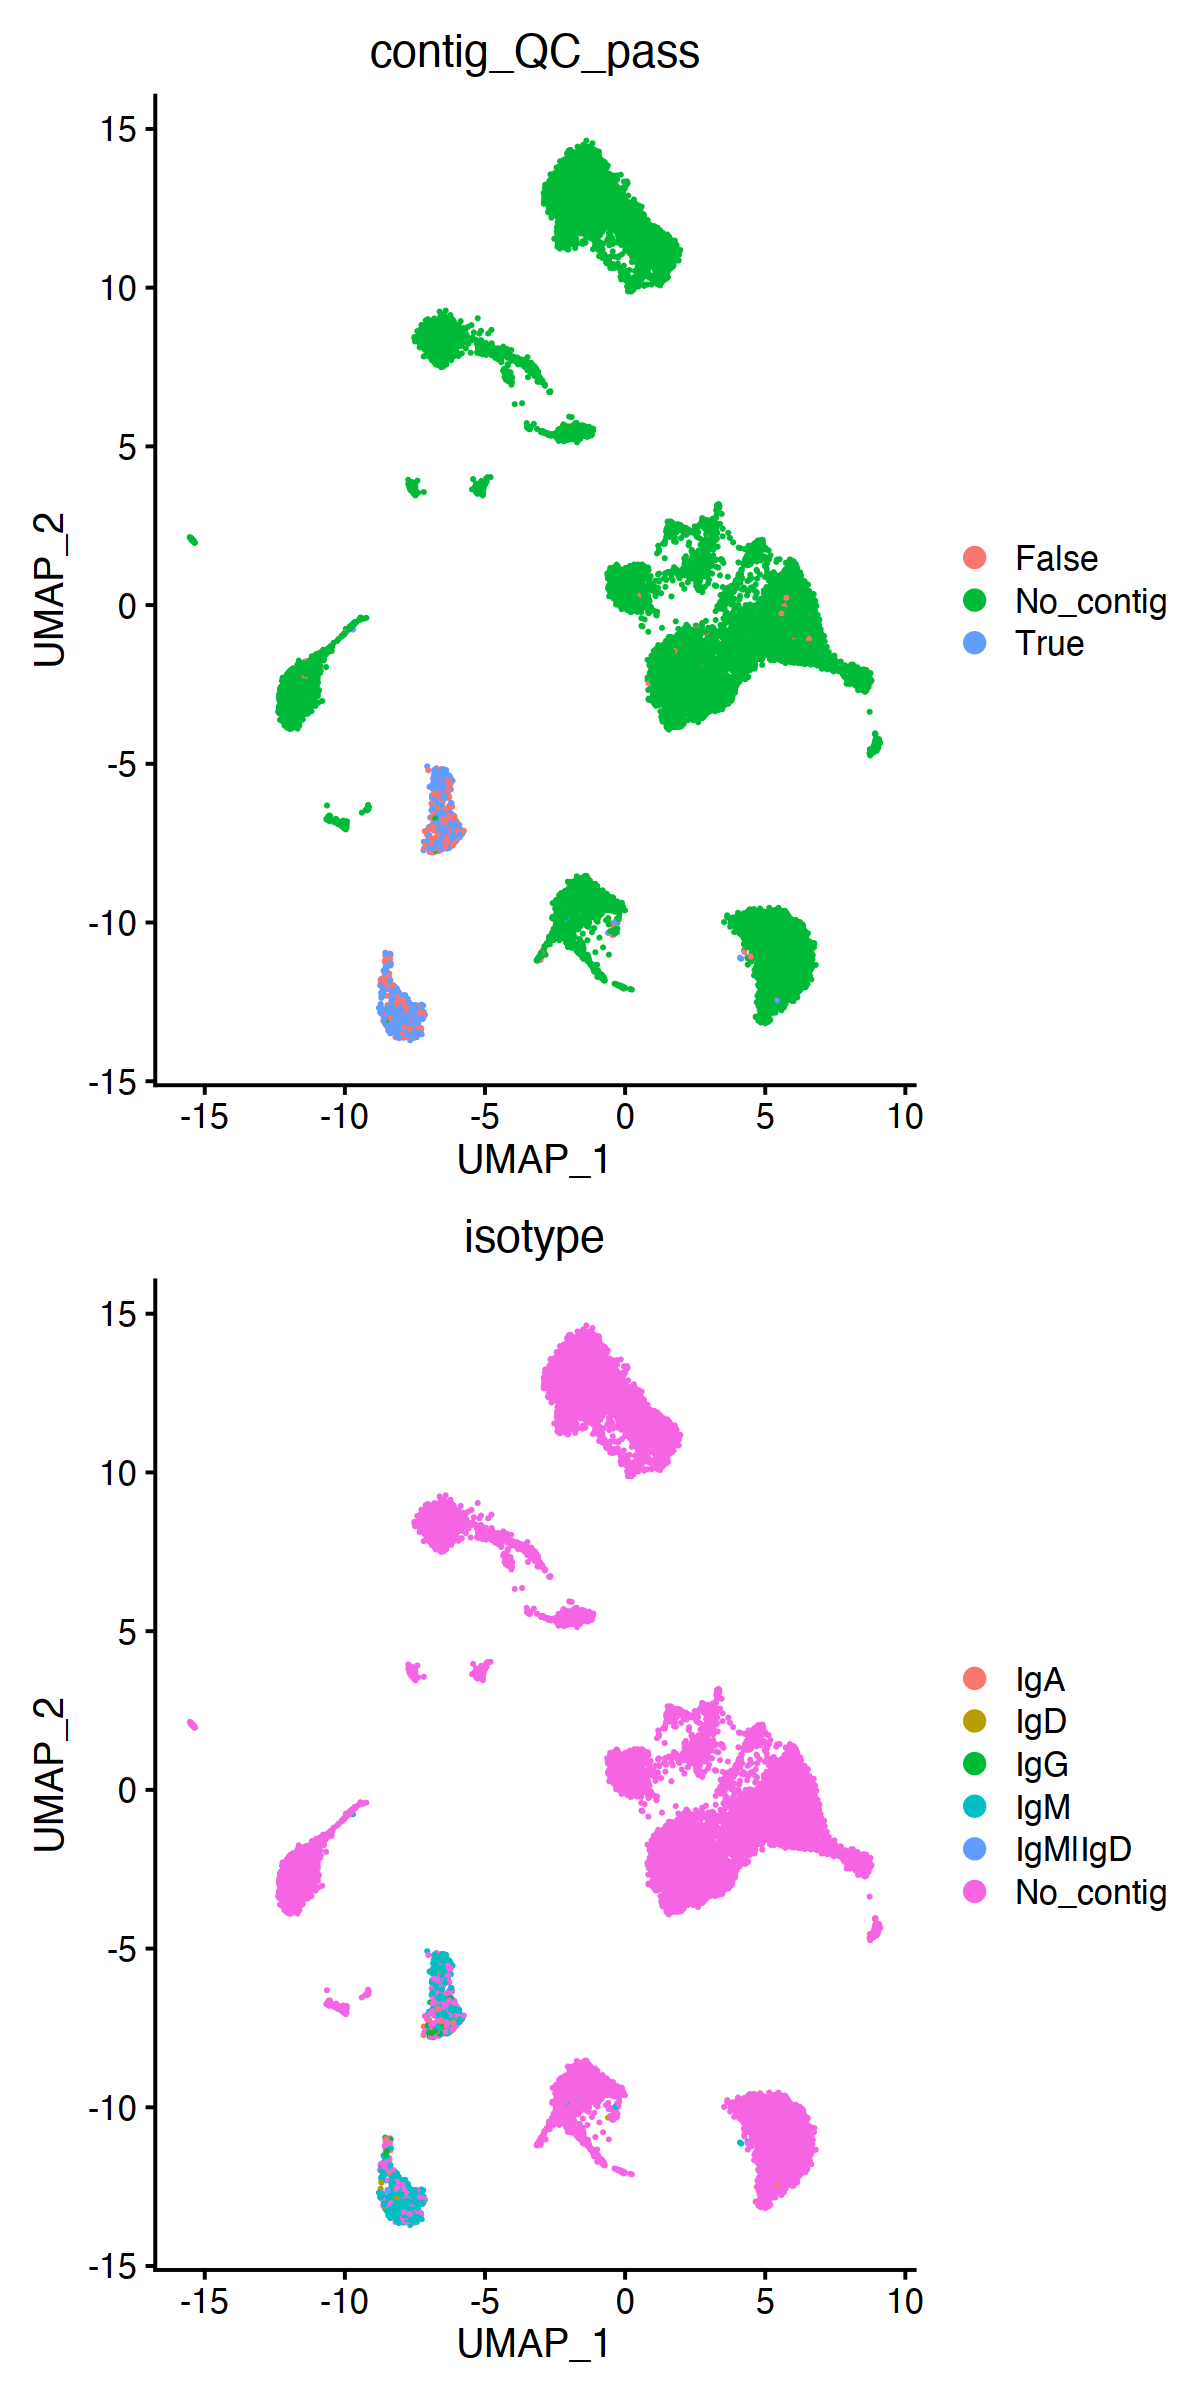

In [9]:
options(repr.plot.width = 6, repr.plot.height = 12, repr.plot.res = 200)
DimPlot(merged, group.by = c("contig_QC_pass", "isotype", "status"), ncol = 1)


If you want to visualise the BCR network, you will have to subset to cells that contain BCR.

In [10]:
merged_bcr <- subset(merged, subset = contig_QC_pass == "True")
merged_bcr


An object of class Seurat 
38224 features across 812 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 2 dimensional reductions calculated: pca, umap

## Plotting BCR network

In [11]:
X_vdj <- adata$obsm["X_vdj"]
X_vdj <- apply(X_vdj, 2, function(x) gsub("NaN", NA, x)) # convert python NAs to R NAs
X_vdj <- apply(X_vdj, 2, function(x) as.numeric(x)) # Make sure they are actually numbers
X_vdj <- as.matrix(X_vdj)
row.names(X_vdj) <- row.names(adata$obs) # will not work if the anndata .obs slot is malformed. the row.names for adata$obs and row.names(merged_bcr@meta.data) should be identical anyway, so just replace with row.names(merged_bcr@meta.data)
X_vdj <- X_vdj[!is.na(X_vdj[, 1]), ]
colnames(X_vdj) <- c("VDJ_1", "VDJ_2")


In [12]:
merged_bcr[["VDJ"]] <- CreateDimReducObject(embeddings = X_vdj, key = "VDJ_", assay = DefaultAssay(merged_bcr))


In [13]:
merged_bcr


An object of class Seurat 
38224 features across 812 samples within 1 assay 
Active assay: RNA (38224 features, 2000 variable features)
 3 dimensional reductions calculated: pca, umap, VDJ

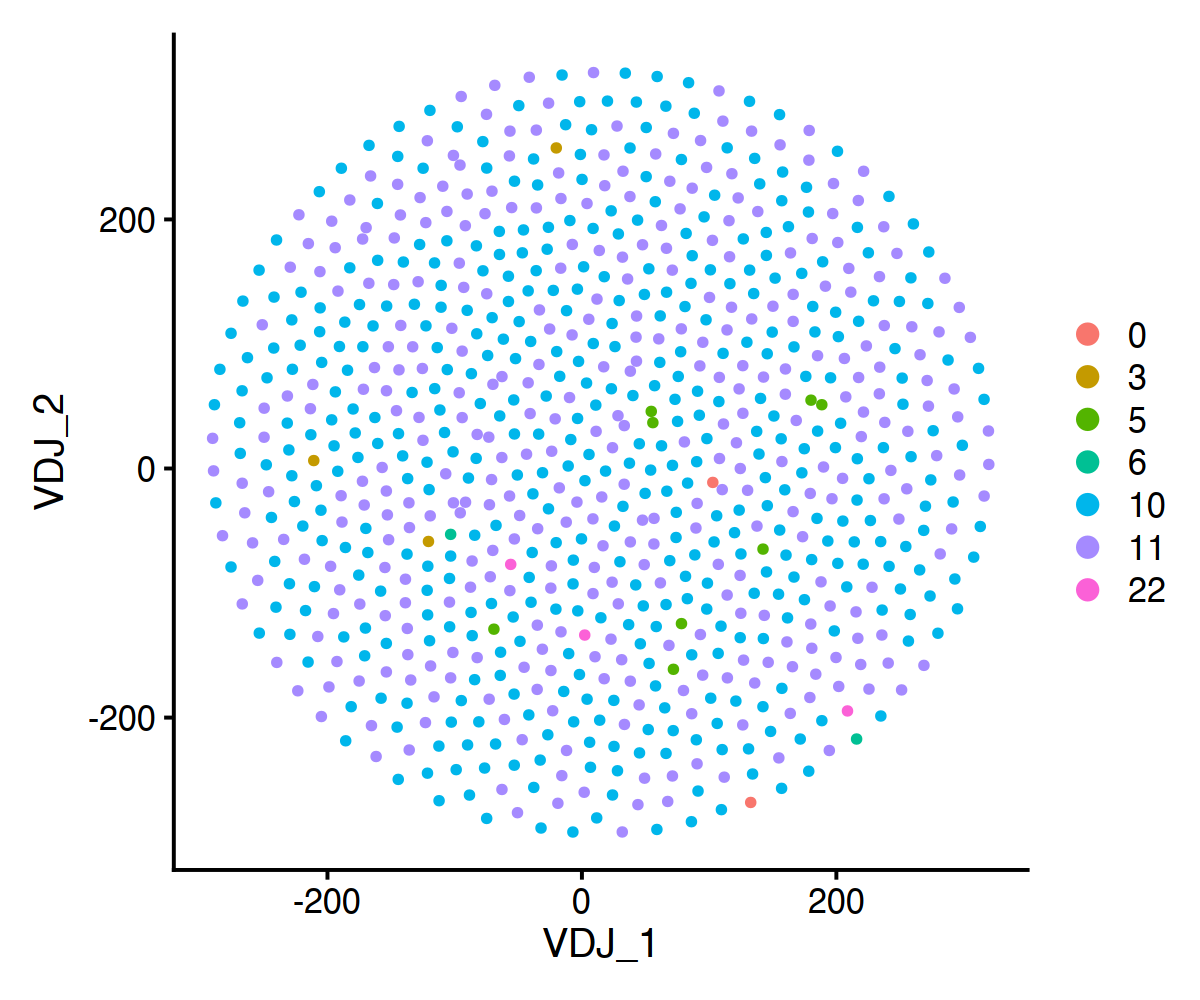

In [14]:
options(repr.plot.width = 6, repr.plot.height = 5, repr.plot.res = 200)
DimPlot(merged_bcr, reduction = "VDJ")


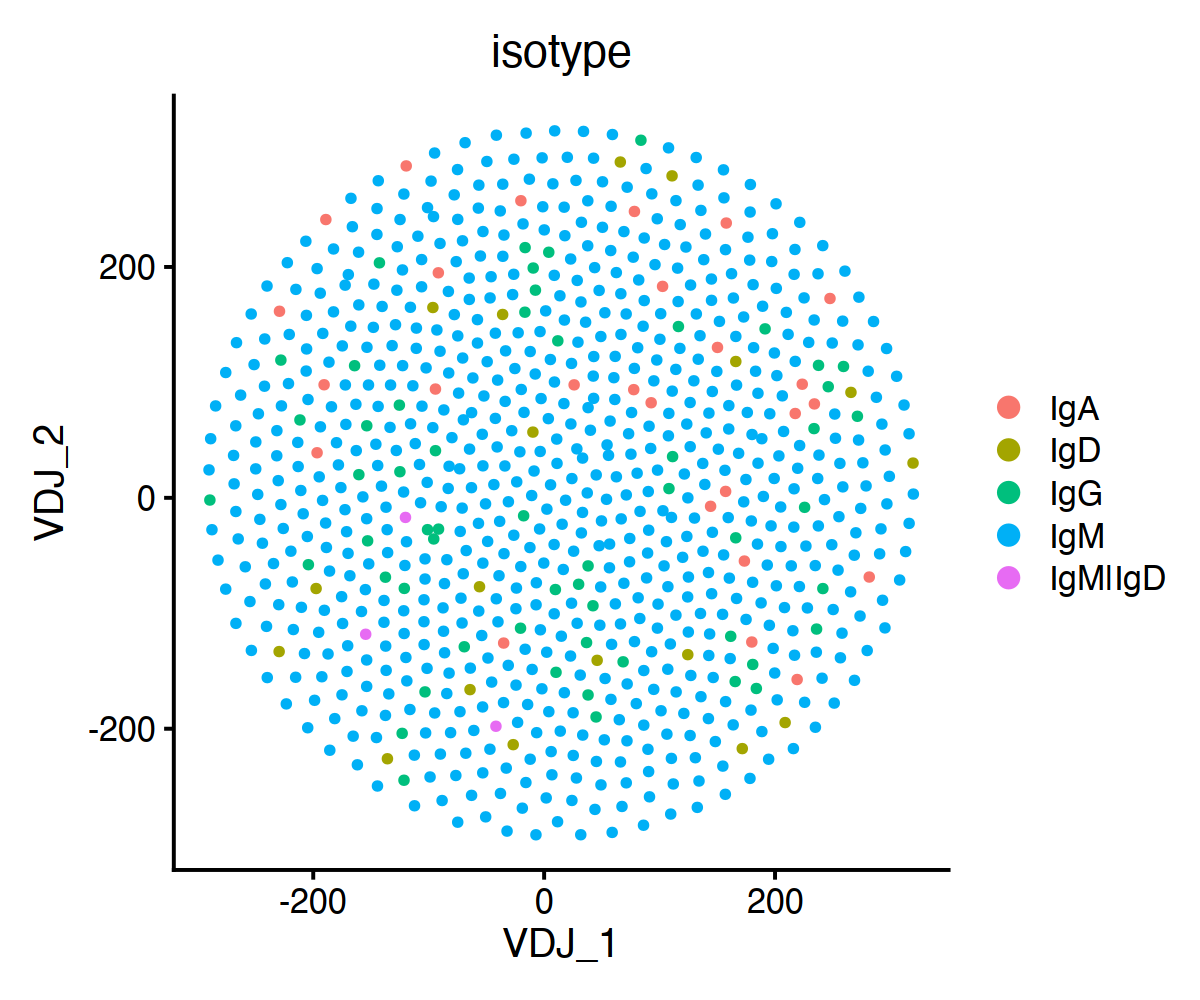

In [15]:
DimPlot(merged_bcr, reduction = "VDJ", group.by = "isotype")


This concludes a quick primer on how to use `dandelion` from R. It may be a bit buggy from time to time due to how reticulate/rpy2 works but hopefully it will be overall alright.

The rest of the functions could be potentially run from R (just be changing `.` to `$` for example), but I haven't tested it. Might be easier to run it through python, or maybe with the new RStudio 4?

In [16]:
sessionInfo()


R version 4.3.1 (2023-06-16)
Platform: aarch64-apple-darwin22.4.0 (64-bit)
Running under: macOS Ventura 13.4.1

Matrix products: default
BLAS:   /opt/homebrew/Cellar/openblas/0.3.23/lib/libopenblasp-r0.3.23.dylib 
LAPACK: /opt/homebrew/Cellar/r/4.3.1/lib/R/lib/libRlapack.dylib;  LAPACK version 3.11.0

locale:
[1] en_AU.UTF-8/en_AU.UTF-8/en_AU.UTF-8/C/en_AU.UTF-8/en_AU.UTF-8

time zone: Australia/Brisbane
tzcode source: internal

attached base packages:
[1] stats     graphics  grDevices utils     datasets  methods   base     

other attached packages:
[1] SeuratObject_4.1.3 Seurat_4.3.0.1     reticulate_1.30   

loaded via a namespace (and not attached):
  [1] deldir_1.0-9           pbapply_1.7-0          gridExtra_2.3         
  [4] rlang_1.1.1            magrittr_2.0.3         RcppAnnoy_0.0.20      
  [7] spatstat.geom_3.2-1    matrixStats_1.0.0      ggridges_0.5.4        
 [10] compiler_4.3.1         png_0.1-8              vctrs_0.6.3           
 [13] reshape2_1.4.4         stringr_1